# Commitment Analysis: Human-Human vs Human-GPT

This notebook analyzes commitment patterns across different experimental conditions:

**1P2G Commitment**: Whether human's first intended goal (`player1FirstDetectedGoal`) matches their final reached goal (`player1FinalReachedGoal`)

**2P3G Commitment**: Whether the first detected shared goal (`firstDetectedSharedGoal`) matches the final reached goal

Analysis compares commitment across human-human and human-gpt game types, with proper player index handling.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

# Set publication standards
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.titlesize': 16,
    'font.family': 'Arial'
})

# Set color palette
colors = {'human-human': 'lightblue', 'human-gpt': 'lightcoral'}
sns.set_palette([colors['human-human'], colors['human-gpt']])


In [ ]:
# Load and prepare data
data_dir = Path.cwd().parent / 'data-original'
excel_files = [f for f in data_dir.glob('*.xlsx') if not f.name.startswith('~$')]

def load_and_process_file(file_path):
    """Load Excel file and add metadata"""
    try:
        df = pd.read_excel(file_path)
        participant_id = file_path.name.split('_')[2]
        df = df.assign(participantID=participant_id, file_id=file_path.name)
        return df
    except Exception as e:
        print(f"Error loading {file_path.name}: {e}")
        return None

# Load all files
all_data = []
for file_path in excel_files:
    df_part = load_and_process_file(file_path)
    if df_part is not None:
        all_data.append(df_part)

# Combine all data
df = pd.concat(all_data, ignore_index=True)

# Load game classification
try:
    class_map = pd.read_csv(data_dir / 'game_classification_results.csv')[['file_id','game_class']]
    df = df.merge(class_map, on='file_id', how='left', suffixes=('', '_from_class_map'))
    print("Merged game classification using file_id")
except Exception as e:
    print('Failed to load game classification:', e)
    df['game_class'] = 'unknown'

# Filter to focus only on human-human and human-gpt game types
df_focused = df[df['game_class'].isin(['human-human', 'human-gpt'])].copy()

print(f"Loaded {len(df)} trials from {len(excel_files)} participants")
print(f"Focused analysis on {len(df_focused)} trials")
print(f"Game type distribution: {df_focused['game_class'].value_counts().to_dict()}")
print(f"Experiment types: {df_focused['experimentType'].value_counts().to_dict()}")


Merged game classification using file_id
Loaded 1005 trials from 29 participants
Focused analysis on 795 trials
Game type distribution: {'human-human': 560, 'human-gpt': 235}
Experiment types: {'1P2G': 274, '2P3G': 272, '2P2G': 181, '1P1G': 68}


In [ ]:
# Define commitment calculation functions

def calculate_commitment_1p2g(row):
    """Calculate commitment for 1P2G: first detected goal == final reached goal"""
    first_goal = row['player1FirstDetectedGoal']
    final_goal = row['player1FinalReachedGoal']

    if pd.isna(first_goal) or pd.isna(final_goal):
        return np.nan

    try:
        first_goal = int(first_goal)
        final_goal = int(final_goal)
        return 1 if first_goal == final_goal else 0
    except (ValueError, TypeError):
        return np.nan

def calculate_human_commitment_2p3g(row):
    """Calculate commitment for human player in 2P3G based on player index"""
    shared_goal = row.get('firstDetectedSharedGoal')
    human_index = row.get('humanPlayerIndex')

    # For human-human games, use player1 as reference
    if pd.isna(human_index):
        human_index = 0

    if pd.isna(shared_goal):
        return np.nan

    # Get human player's final goal based on their index
    if human_index == 0:
        human_final_goal = row.get('player1FinalReachedGoal')
    else:  # human_index == 1
        human_final_goal = row.get('player2FinalReachedGoal')

    if pd.isna(human_final_goal):
        return np.nan

    try:
        shared_goal = int(shared_goal)
        human_final_goal = int(human_final_goal)
        return 1 if shared_goal == human_final_goal else 0
    except (ValueError, TypeError):
        return np.nan

def calculate_gpt_commitment_2p3g(row):
    """Calculate commitment for GPT player in 2P3G based on AI player index"""
    shared_goal = row.get('firstDetectedSharedGoal')
    ai_index = row.get('aiPlayerIndex')

    if pd.isna(shared_goal) or pd.isna(ai_index):
        return np.nan

    # Get AI player's final goal based on their index
    if ai_index == 0:
        ai_final_goal = row.get('player1FinalReachedGoal')
    else:  # ai_index == 1
        ai_final_goal = row.get('player2FinalReachedGoal')

    if pd.isna(ai_final_goal):
        return np.nan

    try:
        shared_goal = int(shared_goal)
        ai_final_goal = int(ai_final_goal)
        return 1 if shared_goal == ai_final_goal else 0
    except (ValueError, TypeError):
        return np.nan

def map_distance_condition_to_human_gpt(row):
    """Map distance conditions to human/gpt perspective based on actual player indices"""
    original_condition = row['distanceCondition']
    human_index = row.get('humanPlayerIndex')

    if original_condition == 'no_new_goal':
        return 'no_new_goal'
    elif original_condition == 'equal_to_both':
        return 'equal_to_both'
    elif original_condition == 'closer_to_player1':
        if human_index == 0:
            return 'closer_to_human'
        elif human_index == 1:
            return 'closer_to_gpt'
        else:
            return original_condition
    elif original_condition == 'closer_to_player2':
        if human_index == 0:
            return 'closer_to_gpt'
        elif human_index == 1:
            return 'closer_to_human'
        else:
            return original_condition
    else:
        return original_condition


In [ ]:
# Prepare data for analysis

# 1P2G data
df_1p2g = df_focused[df_focused['experimentType'] == '1P2G'].copy()
df_1p2g['human_commitment'] = df_1p2g.apply(calculate_commitment_1p2g, axis=1)
df_1p2g['experiment_category'] = '1P2G'

# 2P3G data
df_2p3g = df_focused[df_focused['experimentType'] == '2P3G'].copy()
df_2p3g['human_commitment'] = df_2p3g.apply(calculate_human_commitment_2p3g, axis=1)
df_2p3g['experiment_category'] = '2P3G'

# For human-gpt 2P3G games, also calculate GPT commitment and distance mapping
df_2p3g_human_gpt = df_2p3g[df_2p3g['game_class'] == 'human-gpt'].copy()
if len(df_2p3g_human_gpt) > 0:
    df_2p3g_human_gpt['gpt_commitment'] = df_2p3g_human_gpt.apply(calculate_gpt_commitment_2p3g, axis=1)
    df_2p3g_human_gpt['distance_condition_human_gpt'] = df_2p3g_human_gpt.apply(map_distance_condition_to_human_gpt, axis=1)

# Combine data for overall analysis
commitment_data = pd.concat([df_1p2g, df_2p3g], ignore_index=True)

# Calculate participant-level commitment rates
participant_commitment = commitment_data.groupby(['participantID', 'experiment_category', 'game_class'])['human_commitment'].agg([
    'count', 'mean'
]).reset_index()
participant_commitment.columns = ['participantID', 'experiment_category', 'game_class', 'n_trials', 'commitment_rate']

print(f"\n1P2G data: {len(df_1p2g)} trials")
print(f"2P3G data: {len(df_2p3g)} trials")
print(f"2P3G Human-GPT data: {len(df_2p3g_human_gpt)} trials")
print(f"Participant-level data: {len(participant_commitment)} participants")



1P2G data: 274 trials
2P3G data: 272 trials
2P3G Human-GPT data: 80 trials
Participant-level data: 46 participants


## Figure 1: Commitment in 1P2G and 2P3G by Game Type (Human Commitment)



1P2G Statistical Test:
  Human-Human: n=16, mean=0.828 ± 0.144
  Human-GPT: n=7, mean=0.669 ± 0.158
  T-test: t=2.366, p=0.028

2P3G Statistical Test:
  Human-Human: n=16, mean=0.832 ± 0.200
  Human-GPT: n=7, mean=0.794 ± 0.066
  T-test: t=0.490, p=0.629


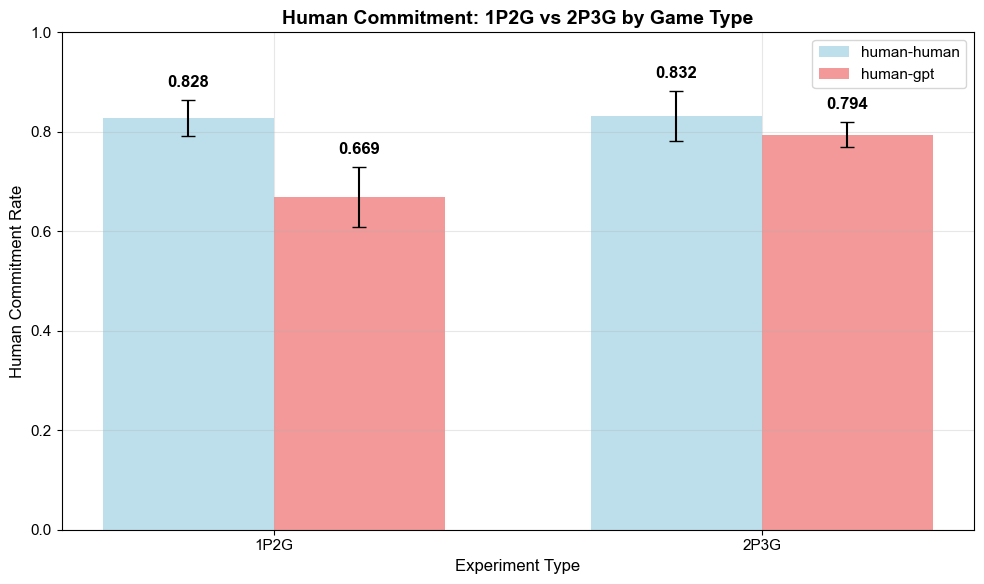

In [ ]:
# Figure 1: Commitment in 1P2G and 2P3G, varied by human-human and human-gpt (measured by human commitment)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Prepare data for plotting
plot_data = participant_commitment.groupby(['experiment_category', 'game_class'])['commitment_rate'].agg(['mean', 'sem']).reset_index()

# Create bar plot
x_pos = np.arange(len(plot_data['experiment_category'].unique()))
width = 0.35

for i, game_type in enumerate(['human-human', 'human-gpt']):
    data = plot_data[plot_data['game_class'] == game_type]
    if len(data) > 0:
        means = data['mean'].values
        sems = data['sem'].values
        bars = ax.bar(x_pos + i*width, means, width, yerr=sems,
                     label=f'{game_type.replace("-", "-")}', color=colors[game_type],
                     alpha=0.8, capsize=5)

        # Add value labels on bars
        for j, (bar, mean, sem) in enumerate(zip(bars, means, sems)):
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + sem + 0.02,
                   f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

ax.set_xlabel('Experiment Type')
ax.set_ylabel('Human Commitment Rate')
ax.set_title('Human Commitment: 1P2G vs 2P3G by Game Type', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos + width/2)
ax.set_xticklabels(plot_data['experiment_category'].unique())
ax.legend()
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)

# Statistical tests and annotations
for exp_type in ['1P2G', '2P3G']:
    exp_data = participant_commitment[participant_commitment['experiment_category'] == exp_type]

    human_human_data = exp_data[exp_data['game_class'] == 'human-human']['commitment_rate'].dropna()
    human_gpt_data = exp_data[exp_data['game_class'] == 'human-gpt']['commitment_rate'].dropna()

    if len(human_human_data) > 0 and len(human_gpt_data) > 0:
        t_stat, p_value = stats.ttest_ind(human_human_data, human_gpt_data)
        print(f"\n{exp_type} Statistical Test:")
        print(f"  Human-Human: n={len(human_human_data)}, mean={human_human_data.mean():.3f} ± {human_human_data.std():.3f}")
        print(f"  Human-GPT: n={len(human_gpt_data)}, mean={human_gpt_data.mean():.3f} ± {human_gpt_data.std():.3f}")
        print(f"  T-test: t={t_stat:.3f}, p={p_value:.3f}")

plt.tight_layout()
plt.show()


## Figure 2: Commitment in 2P3G by Distance Conditions (Human-Human Games)



Human-Human 2P3G Distance Condition Analysis:
  No New Goal: n=48, mean=1.000 ± 0.000
  Equal To Both: n=48, mean=0.771 ± 0.425
  Closer To Player1: n=47, mean=0.830 ± 0.380
  Closer To Player2: n=48, mean=0.729 ± 0.449

ANOVA: F=5.175, p=0.002


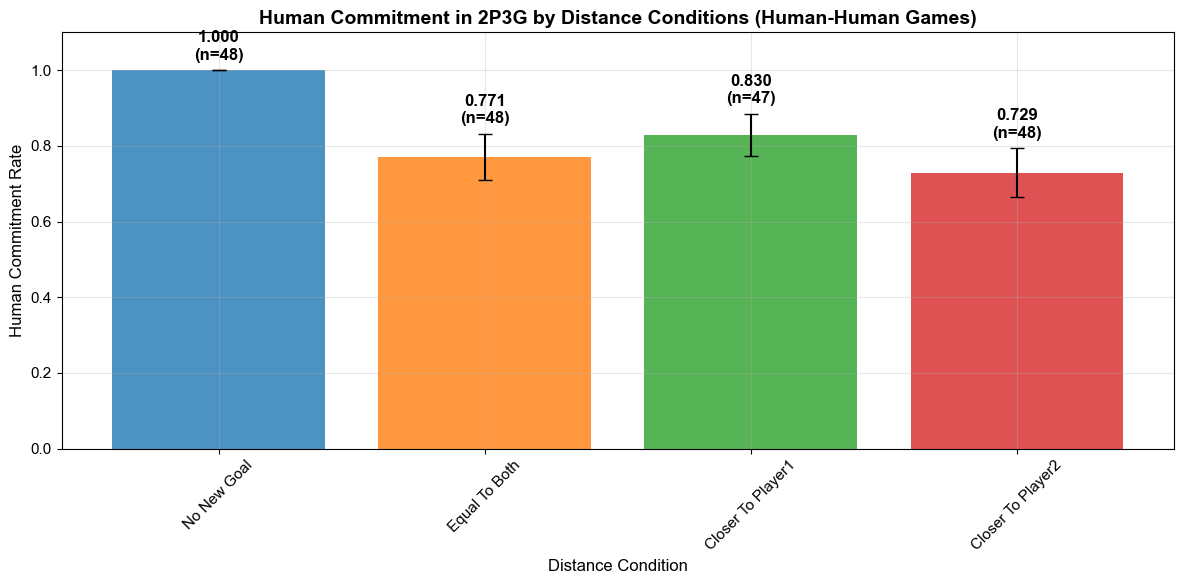

In [ ]:
# Figure 2: Commitment in 2P3G, varied by distance conditions, in human-human

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Focus on human-human 2P3G data
df_2p3g_human_human = df_2p3g[df_2p3g['game_class'] == 'human-human']

# Distance conditions
distance_conditions = ['no_new_goal', 'equal_to_both', 'closer_to_player1', 'closer_to_player2']
distance_colors = {
    'no_new_goal': '#1f77b4',      # Blue (baseline)
    'equal_to_both': '#ff7f0e',    # Orange
    'closer_to_player1': '#2ca02c', # Green
    'closer_to_player2': '#d62728'  # Red
}

# Prepare data
means = []
sems = []
ns = []

for condition in distance_conditions:
    data = df_2p3g_human_human[df_2p3g_human_human['distanceCondition'] == condition]['human_commitment'].dropna()
    means.append(data.mean() if len(data) > 0 else 0)
    sems.append(data.sem() if len(data) > 0 else 0)
    ns.append(len(data))

# Create bar plot
x_pos = np.arange(len(distance_conditions))
bars = ax.bar(x_pos, means, yerr=sems,
              color=[distance_colors[cond] for cond in distance_conditions],
              alpha=0.8, capsize=5)

# Add value labels on bars
for i, (bar, mean, sem, n) in enumerate(zip(bars, means, sems, ns)):
    if mean > 0:
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + sem + 0.02,
               f'{mean:.3f}\n(n={n})', ha='center', va='bottom', fontweight='bold')

ax.set_xlabel('Distance Condition')
ax.set_ylabel('Human Commitment Rate')
ax.set_title('Human Commitment in 2P3G by Distance Conditions (Human-Human Games)', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([cond.replace('_', ' ').title() for cond in distance_conditions], rotation=45)
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3)

# Statistical analysis
print("\nHuman-Human 2P3G Distance Condition Analysis:")
condition_data = []
for i, condition in enumerate(distance_conditions):
    data = df_2p3g_human_human[df_2p3g_human_human['distanceCondition'] == condition]['human_commitment'].dropna()
    if len(data) > 0:
        condition_data.append(data)
        print(f"  {condition.replace('_', ' ').title()}: n={len(data)}, mean={data.mean():.3f} ± {data.std():.3f}")

# ANOVA
if len(condition_data) >= 2:
    f_stat, p_value = stats.f_oneway(*condition_data)
    print(f"\nANOVA: F={f_stat:.3f}, p={p_value:.3f}")

plt.tight_layout()
plt.show()


## Figure 3: Commitment in 2P3G by Distance Conditions (Human-GPT Games)



Human-GPT 2P3G Distance Condition Analysis:

Human Commitment:
  No New Goal: mean=0.947 ± 0.053 (n=19)
  Equal To Both: mean=0.700 ± 0.105 (n=20)
  Closer To Human: mean=0.842 ± 0.086 (n=19)
  Closer To Gpt: mean=0.667 ± 0.114 (n=18)

GPT Commitment:
  No New Goal: mean=0.842 ± 0.086 (n=19)
  Equal To Both: mean=0.600 ± 0.112 (n=20)
  Closer To Human: mean=0.737 ± 0.104 (n=19)
  Closer To Gpt: mean=0.722 ± 0.109 (n=18)

Human commitment: Closer to Human vs Closer to GPT
  t-test: t=1.235, p=0.225
  Difference: +0.175


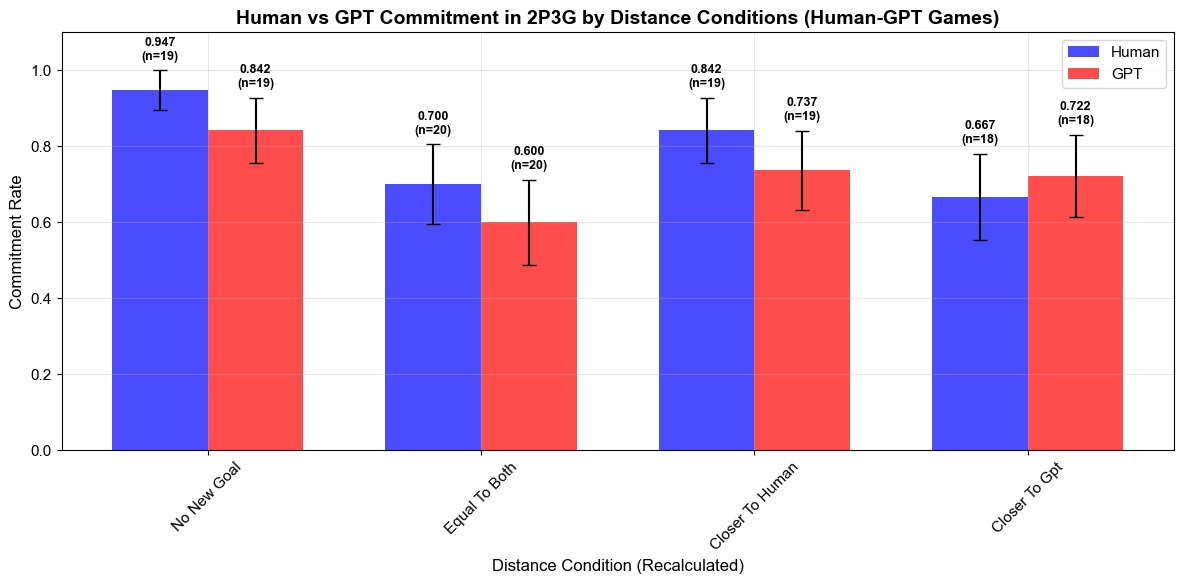

In [ ]:
# Figure 3: Commitment in 2P3G, varied by distance conditions, and human or gpt, in human-gpt

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

if len(df_2p3g_human_gpt) > 0:
    # Use recalculated distance conditions
    human_gpt_distance_conditions = ['no_new_goal', 'equal_to_both', 'closer_to_human', 'closer_to_gpt']

    # Prepare data for plotting
    human_means = []
    human_sems = []
    gpt_means = []
    gpt_sems = []
    human_ns = []
    gpt_ns = []

    for condition in human_gpt_distance_conditions:
        # Human commitment
        h_data = df_2p3g_human_gpt[df_2p3g_human_gpt['distance_condition_human_gpt'] == condition]['human_commitment'].dropna()
        human_means.append(h_data.mean() if len(h_data) > 0 else np.nan)
        human_sems.append(h_data.sem() if len(h_data) > 0 else np.nan)
        human_ns.append(len(h_data))

        # GPT commitment
        g_data = df_2p3g_human_gpt[df_2p3g_human_gpt['distance_condition_human_gpt'] == condition]['gpt_commitment'].dropna()
        gpt_means.append(g_data.mean() if len(g_data) > 0 else np.nan)
        gpt_sems.append(g_data.sem() if len(g_data) > 0 else np.nan)
        gpt_ns.append(len(g_data))

    # Filter out NaN values for plotting
    valid_indices = [i for i in range(len(human_gpt_distance_conditions))
                    if not pd.isna(human_means[i]) and not pd.isna(gpt_means[i])]

    if len(valid_indices) > 0:
        valid_conditions = [human_gpt_distance_conditions[i] for i in valid_indices]
        valid_human_means = [human_means[i] for i in valid_indices]
        valid_human_sems = [human_sems[i] for i in valid_indices]
        valid_gpt_means = [gpt_means[i] for i in valid_indices]
        valid_gpt_sems = [gpt_sems[i] for i in valid_indices]
        valid_human_ns = [human_ns[i] for i in valid_indices]
        valid_gpt_ns = [gpt_ns[i] for i in valid_indices]

        x_pos = np.arange(len(valid_conditions))
        width = 0.35

        bars1 = ax.bar(x_pos - width/2, valid_human_means, width, yerr=valid_human_sems,
                      label='Human', color='blue', alpha=0.7, capsize=5)
        bars2 = ax.bar(x_pos + width/2, valid_gpt_means, width, yerr=valid_gpt_sems,
                      label='GPT', color='red', alpha=0.7, capsize=5)

        # Add value labels on bars
        for i, (bar1, bar2, mean1, mean2, sem1, sem2, n1, n2) in enumerate(
            zip(bars1, bars2, valid_human_means, valid_gpt_means,
                valid_human_sems, valid_gpt_sems, valid_human_ns, valid_gpt_ns)):
            ax.text(bar1.get_x() + bar1.get_width()/2., bar1.get_height() + sem1 + 0.02,
                   f'{mean1:.3f}\n(n={n1})', ha='center', va='bottom', fontsize=9, fontweight='bold')
            ax.text(bar2.get_x() + bar2.get_width()/2., bar2.get_height() + sem2 + 0.02,
                   f'{mean2:.3f}\n(n={n2})', ha='center', va='bottom', fontsize=9, fontweight='bold')

        ax.set_xticks(x_pos)
        ax.set_xticklabels([cond.replace('_', ' ').title() for cond in valid_conditions], rotation=45)

        # Statistical analysis
        print("\nHuman-GPT 2P3G Distance Condition Analysis:")
        print("\nHuman Commitment:")
        for i, condition in enumerate(valid_conditions):
            print(f"  {condition.replace('_', ' ').title()}: mean={valid_human_means[i]:.3f} ± {valid_human_sems[i]:.3f} (n={valid_human_ns[i]})")

        print("\nGPT Commitment:")
        for i, condition in enumerate(valid_conditions):
            print(f"  {condition.replace('_', ' ').title()}: mean={valid_gpt_means[i]:.3f} ± {valid_gpt_sems[i]:.3f} (n={valid_gpt_ns[i]})")

        # Compare closer_to_human vs closer_to_gpt
        if 'closer_to_human' in valid_conditions and 'closer_to_gpt' in valid_conditions:
            human_closer_to_human = df_2p3g_human_gpt[df_2p3g_human_gpt['distance_condition_human_gpt'] == 'closer_to_human']['human_commitment'].dropna()
            human_closer_to_gpt = df_2p3g_human_gpt[df_2p3g_human_gpt['distance_condition_human_gpt'] == 'closer_to_gpt']['human_commitment'].dropna()

            if len(human_closer_to_human) > 0 and len(human_closer_to_gpt) > 0:
                t_stat, p_value = stats.ttest_ind(human_closer_to_human, human_closer_to_gpt)
                print(f"\nHuman commitment: Closer to Human vs Closer to GPT")
                print(f"  t-test: t={t_stat:.3f}, p={p_value:.3f}")
                print(f"  Difference: {human_closer_to_human.mean() - human_closer_to_gpt.mean():+.3f}")

    ax.set_xlabel('Distance Condition (Recalculated)')
    ax.set_ylabel('Commitment Rate')
    ax.set_title('Human vs GPT Commitment in 2P3G by Distance Conditions (Human-GPT Games)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.set_ylim(0, 1.1)
    ax.grid(True, alpha=0.3)

else:
    ax.text(0.5, 0.5, 'No Human-GPT 2P3G data available', ha='center', va='center', transform=ax.transAxes)
    ax.set_title('Human vs GPT Commitment (No Data)')

plt.tight_layout()
plt.show()
